
# 1. Introduction

This notebook has been developed for the purposes of the EMPIR project “Metrology for the Factory of the Future” (Met4FoF) -  Activity A1.2.2 of the Work Package 1.Two laboratories in PTB and CEM posses conventional dynamic calibration set-ups for acceleration sensors under test. The objective of the task is to compare measurement results of the two laboratories, PTB and CEM, provided by the extended dynamic calibration systems. 


## 1.1. State of the art

In conventional dynamic calibration procedures for acceleration sensors, the acceleration used for the sensor input is applied either as **a sinusoidal excitation with a given frequency and amplitude** or as **a singular shock-like excitation characterized by pulse width and intensity**. 
<br>The quantity is then measured by a reference sensor and by the device under test (DUT). The results of DUT are compared to the reference and hence characterized and linked to the SI. In a dynamic calibration situation, the response of the DUT to time-varying input is the major interest. Hence, it is crucial that the mechanical input operates simultaneously and equally on the reference and DUT. Both, the reference and the DUT provide **electrical outputs (typical voltage)** while **the data acquisition electronics** of the system provides **the analogue to digital conversion (ADC).**
In order to connect the reference and the DUT to the ADC system, two analogue channels are needed. In order to get reliable information on the time dependent response, the timing of the data acquisition on the two channels has to be synchronized. This is typically accomplished by provision of a common clock signal to drive the sampling units of the ADC and a common trigger to start (or mark) the beginning of the acquisition. 

## 1.2. The extension of conventional dynamic calibration systems to digital-output sensors 

In a set-up where the DUT is a digital-output sensor,the sampling of the DUT time series is no longer under the control (trigger, clock) of the calibration system. Instead, the DUT comprises its own digitizer unit with a time base independent of the calibration system. In fact, a typical conventional calibration set-up does not provide an input for digital data at all.
The solution to this problem requires two extensions:
1.	A digital acquisition unit (DAU) which is capable to connect to the digital interface of the sensor under calibration and store/transmit the DUT time-series for later analysis
2.	An additional synchronization signal that provides the link between the time-base of the calibration system and the time-base of the DUT.

The concept for the extension of existing facilities for dynamic calibration uses a custom digital acquisition unit microcontroller board with a connected reference time signal for traceable time stamping of acquired data points. This allows for a synchronised data acquisition from the reference measurement and the DUT. The selected sensor for acceleration measurements is a three axial low-g acceleration sensor with digital output, which allows measurements of acceleration in three perpendicular axes.**At the moment and in this notebook, only an X-axis acceleration has been observed.** 
    
The selected laboratories posses their set-ups and the calibration items were calibrated in both set-ups.The analysis required transformation from time domain to the frequency domain, where frequencies and corresponding magnitudes and phases were calculated.The measurement conditions were kept according to the laboratory standard conditions. 

Each laboratory submitted HDFT files containing groups:
- EXPERIMENTS - containing 171 files (experiment) corresponding to the sine excitations
- RAWDATA - where data from ADCs (*voltage, absolute time, absolute time uncertainty*)  and sensors (*absolute time, absolute time uncertainty, acceleration, angular velocity, magnetic flux density and temperature*) can be approached during the measurements
- RAWTRANSFERFUNCTION - *this group contains quantities of interest: frequencies, amplitudes, assigned uncertainties of amplitudes, phases,  assigned uncertainties of phases, excitation amplitudes and assigned uncertainties of excitation amplitudes
- REFERENCEDATA - reference data from ADCs and sensors.

    
| <b>PTB<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 535035904 | 535038464 |
| <b>Quantity<b>  | X Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Min. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |
    
| <b>CEM<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 3167420416 | 31674422976 |
| <b>Quantity<b>  | X Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Min. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |

In [1]:
import h5py
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats
import seaborn as sns
from ipywidgets import widgets, Layout
from IPython import display

# 2.Extract the data

Data for ILC comparison is extracted from the HDF5 files separately for PTB and CEM. The extracted data will be sorted by frequency at the end of the Notebook and saved into Excel file.

In [2]:
def extract_data(filename, sensor_index):
    #explore the HDF5 file, folders and subfolders
    with h5py.File(filename,'r') as f:
        base_items=list(f.items())
        print("\nItems in directory", base_items)
        rawtransfer=f.get("RAWTRANSFERFUNCTION")
        rawtransfer_items=list(rawtransfer.items())
        print("\nItems in reference", rawtransfer_items)
        subgroup=rawtransfer.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250")
        subgroup_items=list(subgroup.items())
        print("\n"+sensor_index+"_MPU_9250 items:",subgroup_items)
        subgroup_acceleration=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration")
        subgroup_acceleration_items=list(subgroup_acceleration.items())
        print("\nAcceleration items:",subgroup_acceleration_items)
        subgroup_acceleration_5mem=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration")
        subgroup_acceleration_5mem_items=list(subgroup_acceleration_5mem.items())
        print("\nAcceleration items_5members:", subgroup_acceleration_5mem_items)
        frequency=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        frequency_items=list(frequency.items())
        print("\nFrequency", frequency_items)
        magnitude=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Magnitude")
        magnitude_items=list(magnitude.items())
        print("\nMagnitude", magnitude_items)
        phase=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Phase")
        phase_items=list(magnitude.items())
        print("\nPhase", phase_items)
        
        
        #extract frequencies, magnitude, phase, uncertainties and all excitation parameters
        frequency_values=np.array(frequency.get("value"))
        magnitude_values=np.array(magnitude.get("value"))
        magnitude_uncertainties=np.array(magnitude.get("uncertainty"))
        phase_values=np.array(phase.get("value"))
        phase_uncertainties=np.array(phase.get("uncertainty"))
        excitation_freq_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        excitation_freq=np.array(excitation_freq_items.get("value"))
        excitation_amp_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_amplitude")
        excitation_amp=np.array(excitation_amp_items.get("value"))
        excitation_amp_uncertainty=np.array(excitation_amp_items.get("uncertainty"))
        
        #join all necessary data in 2D array
        total_array=np.stack((frequency_values,magnitude_values,magnitude_uncertainties,phase_values, phase_uncertainties,excitation_freq,excitation_amp,excitation_amp_uncertainty), axis=1)
        print("\nArray dimensions:", total_array.shape)
        column_names=["Frequency [Hz]", r"$x_{M},$ [m s^-2/m s^-2]",r"$U_{M},$ [m s^-2/m s^-2]", r"$x_{\phi},$ [rad]", r"$U_{\phi},$ [rad]","Excitation_freq [Hz]",r"$x_{Aexcit},$ [m s^-2/m s^-2]",r"$U_{Aexcit},$ [m s^-2/m s^-2]"]
        whole_dataset=pd.DataFrame(total_array, columns=column_names)
        f.close()
        
        
        return whole_dataset

In [4]:
whole_dataset_PTB = extract_data('MPU9250PTB_v5.hdf5',"0x1fe40000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0x1fe40000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250" (1 members)>)]

0x1fe40000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration" (11 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/

In [5]:
whole_dataset_PTB.head(2)

,Frequency [Hz],"$x_{M},$ [m s^-2/m s^-2]","$U_{M},$ [m s^-2/m s^-2]","$x_{\phi},$ [rad]","$U_{\phi},$ [rad]",Excitation_freq [Hz],"$x_{Aexcit},$ [m s^-2/m s^-2]","$U_{Aexcit},$ [m s^-2/m s^-2]"
0,10.0,1.019554,0.002727,-0.094684,0.003022,10.0,2.739,0.000548
1,12.5,1.019093,0.003008,-0.118820,0.006455,12.5,2.744,0.000549


Phase data for PTB must be reverted:

In [6]:
whole_dataset_PTB[[r"$x_{\phi},$ [rad]"]] = whole_dataset_PTB[[r"$x_{\phi},$ [rad]"]]

In [7]:
whole_dataset_PTB.head(2)

,Frequency [Hz],"$x_{M},$ [m s^-2/m s^-2]","$U_{M},$ [m s^-2/m s^-2]","$x_{\phi},$ [rad]","$U_{\phi},$ [rad]",Excitation_freq [Hz],"$x_{Aexcit},$ [m s^-2/m s^-2]","$U_{Aexcit},$ [m s^-2/m s^-2]"
0,10.0,1.019554,0.002727,-0.094684,0.003022,10.0,2.739,0.000548
1,12.5,1.019093,0.003008,-0.118820,0.006455,12.5,2.744,0.000549


In [8]:
whole_dataset_CEM = extract_data('MPU9250CEM_v5.hdf5',"0xbccb0000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0xbccb0000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250" (1 members)>)]

0xbccb0000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration" (11 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/

In [9]:
whole_dataset_CEM[[r"$x_{\phi},$ [rad]"]] = whole_dataset_CEM[[r"$x_{\phi},$ [rad]"]]-np.pi
whole_dataset_CEM.head(2)

,Frequency [Hz],"$x_{M},$ [m s^-2/m s^-2]","$U_{M},$ [m s^-2/m s^-2]","$x_{\phi},$ [rad]","$U_{\phi},$ [rad]",Excitation_freq [Hz],"$x_{Aexcit},$ [m s^-2/m s^-2]","$U_{Aexcit},$ [m s^-2/m s^-2]"
0,80.0,NaN,NaN,NaN,NaN,80.0,NaN,NaN
1,250.0,0.643003,0.000891,-2.375412,0.002897,250.0,126.497513,0.125687


# 3.Data analysis

Cycles in CEM's dataset start with 80.0 Hz and 250.0 Hz instead of 10.0 Hz. These starting points are deleted in order to compare the cycles in a range from 10.0 Hz and 250.Hz.

In [10]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
whole_dataset_CEM_new=whole_dataset_CEM.drop(axis=0,index=delete_rows)

In [11]:
def split_data_by_frequencies(dataset):
    dict_of_frequencies=dict(iter(dataset.groupby('Frequency [Hz]')))
    return dict_of_frequencies
    #list_of_frequencies=np.array([10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])

In [12]:
#check if all frequencies are the same
PTB_separated_by_freq=split_data_by_frequencies(whole_dataset_PTB)
CEM_separated_by_freq=split_data_by_frequencies(whole_dataset_CEM)
CEM_separated_by_freq_new=split_data_by_frequencies(whole_dataset_CEM_new)
print("Frequencies - PTB:",PTB_separated_by_freq.keys())
print("Frequencies - CEM:",CEM_separated_by_freq.keys())

Frequencies - PTB: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])
Frequencies - CEM: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])


In [13]:
PTB_separated_by_freq.get(10).head(1)

,Frequency [Hz],"$x_{M},$ [m s^-2/m s^-2]","$U_{M},$ [m s^-2/m s^-2]","$x_{\phi},$ [rad]","$U_{\phi},$ [rad]",Excitation_freq [Hz],"$x_{Aexcit},$ [m s^-2/m s^-2]","$U_{Aexcit},$ [m s^-2/m s^-2]"
0,10.0,1.019554,0.002727,-0.094684,0.003022,10.0,2.739,0.000548


In [14]:
CEM_separated_by_freq_new.get(10).head(1)

,Frequency [Hz],"$x_{M},$ [m s^-2/m s^-2]","$U_{M},$ [m s^-2/m s^-2]","$x_{\phi},$ [rad]","$U_{\phi},$ [rad]",Excitation_freq [Hz],"$x_{Aexcit},$ [m s^-2/m s^-2]","$U_{Aexcit},$ [m s^-2/m s^-2]"
2,10.0,1.016209,0.004893,-0.094907,0.001665,10.0,2.754331,0.00586


In [15]:
q_names=list(PTB_separated_by_freq.get(10).columns)
list_of_freq=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250]

# 4. En values

The En values for Magnitude, Phase and Excitation amplitude have been calculated according to formula on the figure:

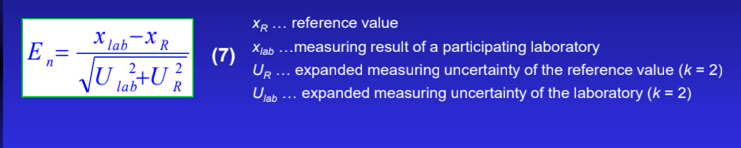

<br>$x_{lab}$ corresponds to the mean value at a specific frequency for the participating laboratory and
<br>$x_{ref}$ corresponds to the mean value at a specific frequency for the reference laboratory 
<br>$U_{lab}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency for the participating laboratory 
<br>$U_{ref}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency for the reference laboratory 
<br>If:<br> |En|<=1.1 - the criteria is satisfied (the original condition is that |En|<=1.0. However, because of the practical reasons, this limit is sometimes enlarged for 10%).
<br>|En|>1.1 - the criteria is not satisfied.
<br>One of the laboratories has been selected as a reference laboratory and other as a participating laboratory.This sequence is not important because it affects only the sign. That is why an absolute values are taken into account. 


# 5. Case study 2: Calculate En values for estimated weighted values

For the weighted mean of a list of data for which each element ${\ x_{i}}$ potentially comes from a different probability distribution with known variance ${\sigma _{i}^{2}}$, one possible choice for the weights is given by the reciprocal of variance [2]:

$$w_{i}={\frac {1}{\sigma _{i}^{2}}}$$

The weighted mean in this case is:

$${\bar {x}}={\frac {\sum _{i=1}^{n}\left({\dfrac {x_{i}}{\sigma _{i}^{2}}}\right)}{\sum _{i=1}^{n}{\dfrac {1}{\sigma _{i}^{2}}}}}$$,

and the standard error of the weighted mean (with variance weights) is:

$$\sigma _{\bar {x}}={\sqrt {\frac {1}{\sum _{i=1}^{n}\sigma _{i}^{-2}}}}$$

Additionally, an effective sample size (ESS) [3] has been calculated at each frequency and for each quantity as:

$$ ESS=\frac {{(\sum _{i=1}^{n} w_{i}})^{2}}{\sum _{i=1}^{n} w_{i}^{2}}$$

This approach has been applied to the magnitude and phase values at each frequency:

$${\bar {x_{M}}}={\frac {\sum _{i=1}^{n}\left({\dfrac {x_{Mi}}{\sigma _{Mi}^{2}}}\right)}{\sum _{i=1}^{n}{\dfrac {1}{\sigma _{Mi}^{2}}}}}$$,

$${\bar {x_{\phi}}}={\frac {\sum _{i=1}^{n}\left({\dfrac {x_{\phi i}}{\sigma _{\phi i}^{2}}}\right)}{\sum _{i=1}^{n}{\dfrac {1}{\sigma _{\phi i}^{2}}}}}$$,


$$\sigma _{\bar {x_{M}}}={\sqrt {\frac {1}{\sum _{i=1}^{n}\sigma _{Mi}^{-2}}}}$$

$$\sigma _{\bar {x_{\phi}}}={\sqrt {\frac {1}{\sum _{i=1}^{n}\sigma _{\phi i}^{-2}}}}$$
In both cases, *n* refers to the number of experiments at a given frequency (*n*=10 for PTB and *n*=9 for CEM).

$\sigma _{M}$  for a single experiment is calculated as   $\frac{U _{M}}{2}$ and $\sigma _{\phi}$ as $\frac{U _{\phi}}{2}$



## 5.1 Weighted values

In [16]:
def calculate_weighted_values(dictionary,names):
    
    weighted_val=np.empty((len(dictionary.keys()),6))
    effective_sample_size=np.empty((len(dictionary.keys()),3))
    
    for val,i in zip(dictionary.values(),range(len(dictionary.keys()))):
        weighted_val[i,0]=np.sum(val[names[1]].values*(1./(val[names[2]].values/2)**2))/np.sum(1./(val[names[2]].values/2)**2)
        weighted_val[i,1]=1./np.sqrt(np.sum(1./(val[names[2]].values/2)**2))
        effective_sample_size[i,0]=((np.sum(1./(val[names[2]].values/2)**2))**2)/np.sum(1./(val[names[2]].values/2)**4)
        
        
        weighted_val[i,2]=np.sum(val[names[3]].values*(1./(val[names[4]].values/2)**2))/np.sum(1./(val[names[4]].values/2)**2)
        weighted_val[i,3]=1./np.sqrt(np.sum(1./(val[names[4]].values/2)**2))
        effective_sample_size[i,1]=((np.sum(1./(val[names[4]].values/2)**2))**2)/np.sum(1./(val[names[4]].values/2)**4)
                     
        weighted_val[i,4]=np.sum(val[names[6]].values*(1./(val[names[7]].values/2)**2))/np.sum(1./(val[names[7]].values/2)**2)
        weighted_val[i,5]=1./np.sqrt(np.sum(1./(val[names[7]].values/2)**2))
        effective_sample_size[i,2]=((np.sum(1./(val[names[7]].values/2)**2))**2)/np.sum(1./(val[names[7]].values/2)**4)
                     
    return weighted_val,effective_sample_size

In [17]:
weighted_values_PTB,effective_sample_size_PTB=calculate_weighted_values(PTB_separated_by_freq,q_names)
weighted_values_CEM,effective_sample_size_CEM=calculate_weighted_values(CEM_separated_by_freq_new,q_names)

column_names_list1  =[name for name in q_names if name != 'Frequency [Hz]' and name!='Excitation_freq [Hz]']
column_names_list2=[r"$wx_{M},$ [m s^-2/m s^-2]",r"$wu_{M},$ [m s^-2/m s^-2]", r"$wx_{\phi},$ [rad]", r"$wu_{\phi},$ [rad]",r"$wx_{Aexcit},$ [m s^-2/m s^-2]",r"$wu_{Aexcit},$ [m s^-2/m s^-2]"]

weighted_values_PTB=pd.DataFrame(weighted_values_PTB, columns=column_names_list2)
weighted_values_CEM=pd.DataFrame(weighted_values_CEM, columns=column_names_list2)

In [18]:
effective_sample_size_PTB[:1,:] #@ 10 Hz for magnitude, phase and excitation amplitude

array([[8.84393792, 9.35844012, 9.99984263]])

In [19]:
effective_sample_size_CEM[:1,:] #@ 10 Hz for magnitude, phase and excitation amplitude

array([[7.34343223, 8.96482514, 8.2404111 ]])

## The overall weighted mean and standard deviation:

This approach has been applied to the magnitude and phase values at each frequency:

$${\bar {x_{M,all}}}={\frac {\sum _{i=1}^{19}\left({\dfrac {x_{Mi}}{\sigma _{Mi}^{2}}}\right)}{\sum _{i=1}^{19}{\dfrac {1}{\sigma _{Mi}^{2}}}}}$$,

$${\bar {x_{\phi,all}}}={\frac {\sum _{i=1}^{19}\left({\dfrac {x_{\phi i}}{\sigma _{\phi i}^{2}}}\right)}{\sum _{i=1}^{19}{\dfrac {1}{\sigma _{\phi i}^{2}}}}}$$,


$$\sigma _{\bar {x_{M, all}}}={\sqrt {\frac {1}{\sum _{i=1}^{19}\sigma _{Mi}^{-2}}}}$$

$$\sigma _{\bar {x_{\phi, all}}}={\sqrt {\frac {1}{\sum _{i=1}^{19}\sigma _{\phi i}^{-2}}}}$$
In both cases, *19* refers to the number of experiments at a given frequency (10 for PTB + 9 for CEM).

$\sigma _{M}$  for a single experiment is calculated as   $\frac{U _{M}}{2}$ and $\sigma _{\phi}$ as $\frac{U _{\phi}}{2}$


In [20]:
#merge all experiments for two labs in the same freqency

from collections import defaultdict
dd = defaultdict(list)
for d in (PTB_separated_by_freq, CEM_separated_by_freq_new): 
    for key, value in d.items():
        dd[key].append(value)

In [21]:
#merge all experiments for two labs in the same freqency
new=dict.fromkeys(list_of_freq, None)
for key,val in zip(list_of_freq,dd.values()):
    a=val[0]
    c=val[1]
    frames=[a,c]
    new[key] = pd.concat(frames)

Additionally, an effective sample size (ESS) [3] has been calculated at each frequency and for each quantity as:

$$ ESS_{,all}=\frac {{(\sum _{i=1}^{19} w_{i}})^{2}}{\sum _{i=1}^{19} w_{i}^{2}}$$

In [22]:
#calculate weighted mean and weighted standard deviation of all experiments
weighted_values_overall,effective_sample_size_overall=calculate_weighted_values(new,q_names)
weighted_values_overall=pd.DataFrame(weighted_values_overall, columns=column_names_list2)

Next, the difference between the weighted mean value of PTB's setup and the overall weighted mean is calculated as:

$${|\bar {x_{M}}|}-{|\bar {x_{M,all}}|}$$, and
$${|\bar {x_{\phi}}|}-{|\bar {x_{\phi,all}}|}$$

The same was applied for the CEM's setup.
The standard pooled deviation is then calculated as:

$$ s_{\bar {p_{M}}}={\sqrt {\frac {(ESS_{M}-1)*\sigma_{\bar {x_{M}}}^2+(ESS_{M,all}-1)*\sigma _{\bar {x_{M,all}}}^2}{ESS_{M}+ESS_{M,all}-2}}}$$


In [23]:
#calculate the difference from the overall weighted mean

difference_mean_PTB=pd.DataFrame((np.abs(weighted_values_PTB)-np.abs(weighted_values_overall))[r"$wx_{M},$ [m s^-2/m s^-2]"],columns=[r"$wx_{M},$ [m s^-2/m s^-2]"])
difference_mean_CEM=pd.DataFrame((np.abs(weighted_values_CEM)-np.abs(weighted_values_overall))[r"$wx_{M},$ [m s^-2/m s^-2]"],columns=[r"$wx_{M},$ [m s^-2/m s^-2]"])

In [24]:
difference_mean_PTB[r"$wx_{\phi},$ [rad]"]=(np.abs(weighted_values_PTB)-np.abs(weighted_values_overall))[r"$wx_{\phi},$ [rad]"]
difference_mean_CEM[r"$wx_{\phi},$ [rad]"]=(np.abs(weighted_values_CEM)-np.abs(weighted_values_overall))[r"$wx_{\phi},$ [rad]"]

In [25]:
effective_sample_size_PTB_1=pd.DataFrame(effective_sample_size_PTB)
effective_sample_size_overall_1=pd.DataFrame(effective_sample_size_overall)
effective_sample_size_CEM_1=pd.DataFrame(effective_sample_size_CEM)

In [26]:

s_pooled_PTB_mag=np.sqrt(((effective_sample_size_PTB_1[0]-1)*weighted_values_PTB[r"$wu_{M},$ [m s^-2/m s^-2]"].values**2+(effective_sample_size_overall_1[0]-1)*weighted_values_overall[r"$wu_{M},$ [m s^-2/m s^-2]"].values**2)/(effective_sample_size_PTB_1[0]+effective_sample_size_overall_1[0]-2))
s_pooled_CEM_mag=np.sqrt(((effective_sample_size_CEM_1[0]-1)*weighted_values_PTB[r"$wu_{M},$ [m s^-2/m s^-2]"].values**2+(effective_sample_size_overall_1[0]-1)*weighted_values_overall[r"$wu_{M},$ [m s^-2/m s^-2]"].values**2)/(effective_sample_size_CEM_1[0]+effective_sample_size_overall_1[0]-2))
s_pooled_PTB_ph=np.sqrt(((effective_sample_size_PTB_1[1]-1)*weighted_values_PTB[r"$wu_{\phi},$ [rad]"].values**2+(effective_sample_size_overall_1[1]-1)*weighted_values_overall[r"$wu_{\phi},$ [rad]"].values**2)/(effective_sample_size_PTB_1[1]+effective_sample_size_overall_1[1]-2))
s_pooled_CEM_ph=np.sqrt(((effective_sample_size_CEM_1[1]-1)*weighted_values_PTB[r"$wu_{\phi},$ [rad]"].values**2+(effective_sample_size_overall_1[1]-1)*weighted_values_overall[r"$wu_{\phi},$ [rad]"].values**2)/(effective_sample_size_CEM_1[1]+effective_sample_size_overall_1[1]-2))

from scipy import stats

t_mag_PTB=[stats.t.ppf(1-0.025, effective_sample_size_PTB_1[0][val]+effective_sample_size_overall_1[0][val]-2) for val in range(len(effective_sample_size_PTB_1[0]))]
t_mag_CEM=[stats.t.ppf(1-0.025, effective_sample_size_CEM_1[0][val]+effective_sample_size_overall_1[0][val]-2) for val in range(len(effective_sample_size_CEM_1[0]))]
t_ph_PTB=[stats.t.ppf(1-0.025, effective_sample_size_PTB_1[1][val]+effective_sample_size_overall_1[1][val]-2) for val in range(len(effective_sample_size_PTB_1[1]))]
t_ph_CEM=[stats.t.ppf(1-0.025, effective_sample_size_CEM_1[1][val]+effective_sample_size_overall_1[1][val]-2) for val in range(len(effective_sample_size_CEM_1[1]))]


The confidence interval of the difference between two population means is:
$${|\bar {x_{M}}|}-{|\bar {x_{M,all}}} \pm t_{\frac{\alpha}{2}} * s_{p}*\sqrt{\frac{1}{ESS}+\frac{1}{ESS_{all}}}$$,
where $t_{\frac{\alpha}{2}}$ has $ESS+ESS_{all}-2$ degrees of freedom

In [27]:
last_mem_mag_PTB=np.sqrt(1/effective_sample_size_PTB_1[0]+1/effective_sample_size_overall_1[0])
last_mem_mag_CEM=np.sqrt(1/effective_sample_size_CEM_1[0]+1/effective_sample_size_overall_1[0])

last_mem_ph_PTB=np.sqrt(1/effective_sample_size_PTB_1[1]+1/effective_sample_size_overall_1[1])
last_mem_ph_CEM=np.sqrt(1/effective_sample_size_CEM_1[1]+1/effective_sample_size_overall_1[1])

/home/seeger01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


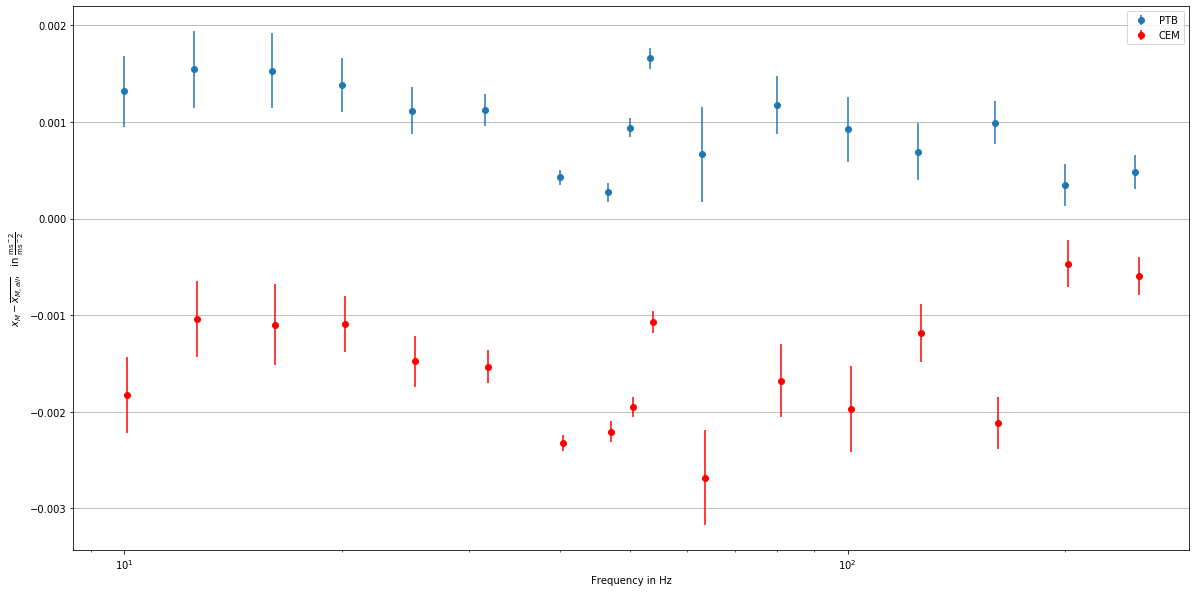

In [45]:
fig,ax=plt.subplots(figsize=(20,10))
x=np.array(list_of_freq)
x1=x*1.01#OFFSET 1% offset to better ditinguish both labs
y= difference_mean_PTB[r"$wx_{M},$ [m s^-2/m s^-2]"].values
y1=difference_mean_CEM[r"$wx_{M},$ [m s^-2/m s^-2]"].values
error=s_pooled_PTB_mag*t_mag_PTB*last_mem_mag_PTB
error1=s_pooled_CEM_mag*t_mag_CEM*last_mem_mag_CEM
ax.errorbar(x, y,yerr=error, linestyle="",marker="o",label="PTB")
ax.errorbar(x1, y1,yerr=error1, linestyle="",marker="o",label="CEM",color="red")
ax.set_xlabel("Frequency in Hz")
ax.set_ylabel(r"$x_{M}-\overline{x_{M,all}},$  in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")
ax.set_xscale('log')
ax.legend()
ax.yaxis.grid() 
fig.show()

/home/seeger01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


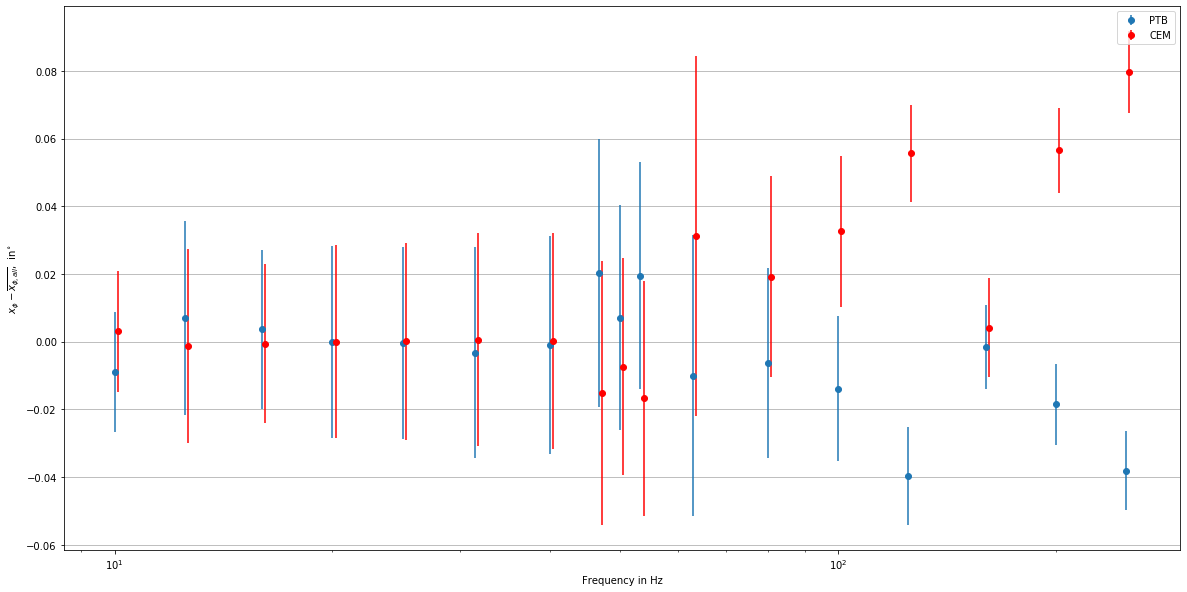

In [44]:
fig,ax=plt.subplots(figsize=(20,10))
x=np.array(list_of_freq)
x1=x*1.01#OFFSET 1% offset to better ditinguish both labs
y= difference_mean_PTB[r"$wx_{\phi},$ [rad]"].values
y1=difference_mean_CEM[r"$wx_{\phi},$ [rad]"].values
error=s_pooled_PTB_ph*t_ph_PTB*last_mem_ph_PTB
error1=s_pooled_CEM_ph*t_ph_CEM*last_mem_ph_CEM
ax.errorbar(x, np.rad2deg(y),yerr=np.rad2deg(error), linestyle="",marker="o",label="PTB")
ax.errorbar(x1, np.rad2deg(y1),yerr=np.rad2deg(error1), linestyle="",marker="o",label="CEM",color="red")
ax.set_xlabel("Frequency in Hz")
ax.set_ylabel(r"$x_{\phi}-\overline{x_{\phi,all}},$ in$^\circ$")
ax.set_xscale('log')
ax.yaxis.grid() 
ax.legend()
fig.show()

## 5.2 En values for weighted data

In [29]:
def calculate_En_values_weighted(df1,df2,names):
    En_values=np.empty((df1.shape[0],2))
    
    for i in range (df1.shape[0]):
            En_values[:,0]=np.abs(((df1[names[0]].values-df2[names[0]].values)/(2*(np.sqrt(df1[names[1]].values**2 +df2[names[1]].values**2)))))
            En_values[:,1]=np.abs(((df1[names[2]].values-df2[names[2]].values)/(2*(np.sqrt(df1[names[3]].values**2 +df2[names[3]].values**2)))))
            #En_values[:,2]=np.abs(((df1[names[4]].values-df2[names[4]].values)/(2*(np.sqrt(df1[names[5]].values**2 +df2[names[5]].values**2))))) 
    return En_values  

In [30]:
weighted_values_PTB.head(2)

,"$wx_{M},$ [m s^-2/m s^-2]","$wu_{M},$ [m s^-2/m s^-2]","$wx_{\phi},$ [rad]","$wu_{\phi},$ [rad]","$wx_{Aexcit},$ [m s^-2/m s^-2]","$wu_{Aexcit},$ [m s^-2/m s^-2]"
0,1.019178,0.000501,-0.094700,0.000484,2.751078,0.000087
1,1.018499,0.000578,-0.118723,0.000766,2.755883,0.000087


In [31]:
En_values_weighted=calculate_En_values_weighted(weighted_values_PTB,weighted_values_CEM,column_names_list2)
#En_values_weighted_exp=calculate_En_values_weighted(weighted_values_PTB,weighted_values_CEM,"expanded uncertainty",q_names)

Text(0.5, 1, 'En values-not exp.uncertainty')

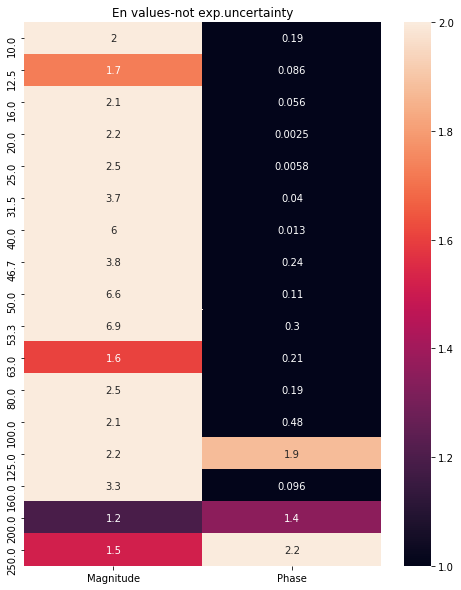

In [32]:

plt.figure(figsize=(8,10))

sns.heatmap(En_values_weighted, vmax=2, vmin=1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase"] )
plt.title("En values-not exp.uncertainty")

#magnitudes at low freq - bad SNR 

The results are similar to those in 3_Case_study_1.ipynb and different from the Type A approach. The En criteria is satisfied for phase values at all frequencies while magnitude values are not in agreement.

## 5.3 F-test

A Statistical F Test uses an F Statistic to compare two variances, s1 and s2, by dividing them. The result is always a positive number (because variances are always positive). The equation for comparing two variances with the F-test is:

$$ F = \frac {{s_{1}}^{2}}{{s_{2}}^{2}}$$

The population variances are equal when running an F Test. Therefore, the null hypothesis will always be that the variances are equal.

<br>The null hypothesis H0: ${s_{1}}^{2} = {s_{2}}^{2}$
<br>The research hypothesis H1: ${s_{1}}^{2} != {s_{2}}^{2}$,

where s1 and s2 correspond to the weighted standard errors calculated for each quantity (Magnitude, Phase and Excitation amplitude) at each frequency.

<br>Several assumptions are made for the test: 
<br>1) The population must be approximately normally distributed (i.e. fit the shape of a bell curve) in order to use the test. 
<br>2) The samples must be independent events. 
<br>3) The larger variance should always go in the numerator to force the test into a right-tailed test. Right-tailed tests are easier to calculate. **Because of this, sometimes the index 1 corresponds to PTB and sometimes to CEM.**
<br>For this two-tailed test, the level of significance, $\alpha$ = 5% is divided  by 2 before finding the right critical value.
Degrees of freedom are ESS-1 for both laboratories.

The calculated F-value is then compared to the critical F value. If F>Fcrit, and, additionally, p-value<$\alpha$, the null hypothesis can be rejected.

In [33]:
Fval=np.empty((weighted_values_PTB.shape[0],2))
differences=np.empty((weighted_values_PTB.shape[0],2))
differences[:,0]=weighted_values_CEM[column_names_list2[1]]**2-weighted_values_PTB[column_names_list2[1]]**2
differences[:,1]=weighted_values_CEM[column_names_list2[3]]**2-weighted_values_PTB[column_names_list2[3]]**2

print (differences[:3]) # some st. deviations in phase are higher for PTB - it shall go to numerator

[[ 9.72507571e-08 -1.55451215e-07]
 [-1.09163758e-07 -4.77165673e-07]
 [-6.59488314e-08 -3.08088546e-07]]


In [34]:
Fval[:,0]= (weighted_values_CEM[column_names_list2[1]].values**2)/(weighted_values_PTB[column_names_list2[1]].values**2)

Fval[:1,1]=(weighted_values_CEM[column_names_list2[3]].values[:1]**2)/(weighted_values_PTB[column_names_list2[3]].values[:1]**2)
Fval[2:7,1]=(weighted_values_PTB[column_names_list2[3]].values[2:7]**2)/(weighted_values_CEM[column_names_list2[3]].values[2:7]**2)
Fval[7:,1]=(weighted_values_CEM[column_names_list2[3]].values[7:]**2)/(weighted_values_PTB[column_names_list2[3]].values[7:]**2)

In [35]:
p_val=np.empty((Fval.shape))
Fcrit=np.empty((Fval.shape))

Fcrit[:,0]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_CEM[:,0]-1, dfd=effective_sample_size_PTB[:,0]-1)
p_val[:,0]=scipy.stats.f.sf(Fval[:,0],effective_sample_size_CEM[:,0]-1,effective_sample_size_PTB[:,0]-1)

Fcrit[:1,1]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_CEM[:1,1]-1, dfd=effective_sample_size_PTB[:1,1]-1)
p_val[:1,1]=scipy.stats.f.sf(Fval[:1,1],effective_sample_size_CEM[:1,1]-1,effective_sample_size_PTB[:1,1]-1)

Fcrit[2:7,1]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_PTB[2:7,1]-1, dfd=effective_sample_size_CEM[2:7,1]-1)
p_val[2:7,1]=scipy.stats.f.sf(Fval[2:7,1],effective_sample_size_PTB[2:7,1]-1,effective_sample_size_CEM[2:7,1]-1)

Fcrit[7:,1]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_CEM[7:,1]-1, dfd=effective_sample_size_PTB[7:,1]-1)
p_val[7:,1]=scipy.stats.f.sf(Fval[7:,1],effective_sample_size_CEM[7:,1]-1,effective_sample_size_PTB[7:,1]-1)

In [36]:
F_differences=pd.DataFrame(Fval-Fcrit,columns=['Magnitude', "Phase"],index=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])
p_val=pd.DataFrame(p_val,columns=['Magnitude', "Phase"],index=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])

In [37]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s > 0
    return ['background-color: yellow' if v else '' for v in is_max]

In [38]:
# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()

with widget1:
    display.display(F_differences.style.set_caption('F-Fcrit').apply(highlight_max))
with widget2:
    display.display(p_val.style.applymap(lambda x: 'background-color : red' if x<0.05 else 'background-color : green').set_caption('p-val'))


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    
# create Horisontal Box container
hbox = widgets.HBox([widget1, widget2], layout=box_layout)

# render hbox
hbox

The null-hypothesis about equality of the weighted magnitude variances between PTB and CEM can be rejected only at 40.0 Hz and 46.7 Hz.
On the other hand, the null-hypothesis about equality of the weighted phase variances between PTB and CEM cannot be reject in a range (16.0 Hz - 40.0 Hz).

# References

[1] https://www.investopedia.com/terms/c/coefficientofvariation.asp
<br>[2] https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>[3] https://en.wikipedia.org/wiki/Effective_sample_size
<br>[4] https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>[5] https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/